# Cuda Simulator

In [26]:
%load_ext pyinstrument
"""Setup"""
import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
#from viz import *
from optics_cuda import *

#drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


In [27]:
%%time
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

###
photon_count = np.int32(1000000)
source_size = np.float32(10)
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
###
photons = LambertianSource(source_size, source_size).make_photons(photon_count)

CPU times: user 2.28 ms, sys: 423 µs, total: 2.7 ms
Wall time: 1.71 ms


In [28]:
import cupy as cp
import math
import matplotlib.pyplot as plt
import numpy as np
from cupyx import jit

@jit.rawkernel()
def histogram(input_data_1: cp.ndarray,
              input_data_2: cp.ndarray,
              mapper: np.int32,
              global_histogram: cp.ndarray,
              size: np.int32,
              min_value: np.float32,
              bin_width: np.float32) -> None:
    """ input_data_1: cp.ndarray[np.float32]
        input_data_2: cp.ndarray[np.float32], use for phi, 1:x, 2:y
        mapper: 0 = none, 1 = phi, 2 = theta
        global_histogram: cp.ndarray[np.int32]
    """
    # Create a histogram for this block.  Size must match bins and threads.
    block_histogram = jit.shared_memory(np.int32, 128)

    # Alloc is not zeroed so do it.
    block_histogram[jit.threadIdx.x] = 0

    # Wait for all threads to set their zeros.
    jit.syncthreads()
    
    # Fill up the block-local histogram.
    # Adjacent threads get adjacent data:
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    # If there's more than one grid (not recommended) then do that too:
    ntid = jit.gridDim.x * jit.blockDim.x
    
    for i in range(tid, size, ntid):
        if mapper == 1:
            mapped_data = cp.arctan2(input_data_2[i], input_data_1[i])
        elif mapper == 2:
            mapped_data = cp.arccos(input_data_1[i])
        else:
            mapped_data = input_data_1[i]
        bucket_idx = int((mapped_data - min_value) // bin_width)
        bucket_idx = int(min(max(bucket_idx, 0), 127)) # must match above
        jit.atomic_add(block_histogram, bucket_idx, 1)

    # Wait for all the threads to do it.
    jit.syncthreads()

    # Sum the block-local histograms into a global histogram.
    jit.atomic_add(global_histogram, jit.threadIdx.x, block_histogram[jit.threadIdx.x])



In [29]:
def plot_histogram_slices(
    photon_batch: Photons,
    size: np.int32,
    suptitle: str,
    x_min: float,
    x_max: float,
    y_min: float,
    y_max: float,
    z_min: float,
    z_max: float,
    theta_min: float = 0,
    theta_max: float = np.pi,
    phi_min: float = -np.pi,
    phi_max: float = np.pi) -> None:

    bins = 128 # matches threads etc
    threads_per_block = bins # because the threads write back
    grid_size = (int(math.ceil(size / threads_per_block)), 1, 1)
    block_size = (threads_per_block, 1, 1)

    null_vector = cp.empty(0, dtype=np.float32)
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(suptitle)
    
    h = cp.zeros(bins, dtype=np.int32)
    histogram(grid_size, block_size, (photon_batch.r_x, null_vector, np.int32(0), h, size, np.float32(x_min), np.float32((x_max-x_min)/bins)))
    axes = plt.subplot(331)
    plt.plot(np.linspace(x_min, x_max, bins), h.get(), snap=False)
    axes.set_title("photons per bucket by x")
    axes.set_xlabel("x dimension (TODO: unit)")
    axes.set_ylabel("photon count per bucket (TODO: density)")
    
    h = cp.zeros(bins, dtype=np.int32)
    histogram(grid_size, block_size, (photon_batch.r_y, null_vector, np.int32(0), h, size, np.float32(y_min), np.float32((y_max-y_min)/bins)))
    axes = plt.subplot(332)
    plt.plot(np.linspace(y_min, y_max, bins), h.get(), snap=False)
    axes.set_title("photons per bucket by y")
    axes.set_xlabel("y dimension (TODO: unit)")
    axes.set_ylabel("photon count per bucket (TODO: density)")

    h = cp.zeros(bins, dtype=np.int32)
    histogram(grid_size, block_size, (photon_batch.r_z, null_vector, np.int32(0), h, size, np.float32(z_min), np.float32((z_max-z_min)/bins)))
    axes = plt.subplot(333)
    plt.plot(np.linspace(z_min, z_max, bins), h.get(), snap=False)
    axes.set_title("photons per bucket by z")
    axes.set_xlabel("z dimension (TODO: unit)")
    axes.set_ylabel("photon count per bucket (TODO: density)")

    h = cp.zeros(bins, dtype=np.int32)
    histogram(grid_size, block_size, (photon_batch.ez_y, photon_batch.ez_x, np.int32(1), h, size, np.float32(phi_min), np.float32((phi_max-phi_min)/bins)))
    axes = plt.subplot(334)
    plt.plot(np.linspace(phi_min, phi_max, bins), h.get(), snap=False)
    axes.set_title("photons per bucket by phi")
    axes.set_xlabel("azimuth (phi) (degrees)")
    axes.set_ylabel("photon count per bucket (TODO: density)")

    h = cp.zeros(bins, dtype=np.int32)
    histogram(grid_size, block_size, (photon_batch.ez_z, null_vector, np.int32(2), h, size, np.float32(theta_min), np.float32((theta_max-theta_min)/bins)))
    axes = plt.subplot(335)
    plt.plot(np.linspace(theta_min, theta_max, bins), h.get(), snap=False)
    axes.set_title("photons per bucket by theta")
    axes.set_xlabel("polar angle (theta) (degrees)")
    axes.set_ylabel("photon count per bucket (TODO: density)")

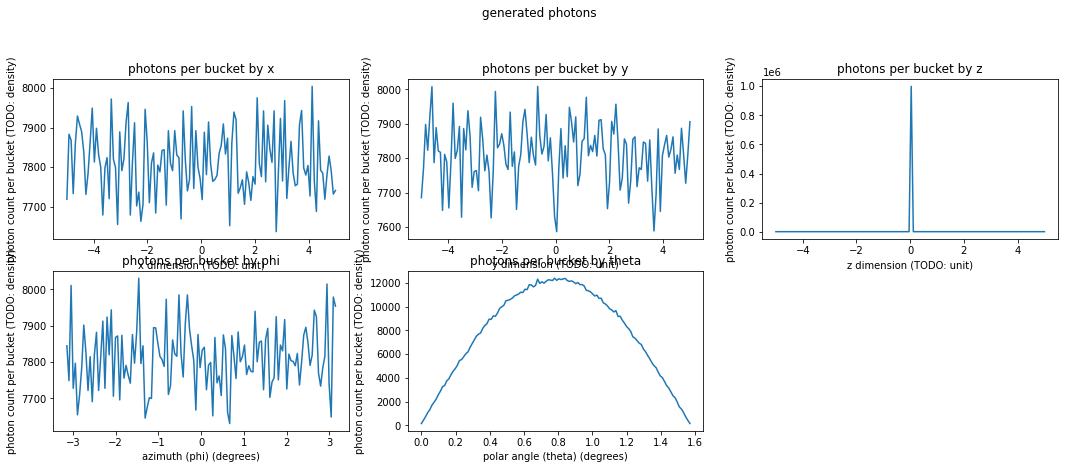

In [30]:
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, photon_count, "generated photons", -source_size/2, source_size/2, -source_size/2, source_size/2, z_min=-5, z_max=5, theta_max = np.pi/2)

In [ ]:
"""Look at the photons in 3d."""
photons_viz = Photon.sample(photons, 1000)
plot_rays([photons_viz], 5, 20, 15, 1, rectangles=[source_box])

In [ ]:
%%pyinstrument
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
###

print(f"LED emitted photons: {Photon.countAlive(photons)}")
lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")

In [ ]:
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000, theta_max = np.pi/2)

In [ ]:
%%pyinstrument
""" Diffuse through the diffuser. """
print(f"diffuser-incident photons: {Photon.countAlive(photons)}")
diffuser = Diffuser(g = 0.64, absorption = 0.16)
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
diffused_photons_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=1000)

In [ ]:
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz], elev = 10, azim = 30, size = max(lightbox_height, lightbox_size), arrow_length = 50,
          rectangles=[source_box, lightbox_box])

In [ ]:
%%pyinstrument
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# size might be 10cm square?
###
reflector_distance = 100000 # 1 m
reflector_box = [-500, 500, -500, 500, reflector_distance]
###
print(f"diffuser-transmitted photons: {Photon.countAlive(photons)}")
propagateToReflector(photons, location = reflector_distance, size = 1000)
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_reflector_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=reflector_distance)

In [ ]:
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz ], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 500,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
%%pyinstrument
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {Photon.countAlive(photons)}")
reflector = Diffuser(g = -0.9925, absorption=0.0)
reflector.diffuse(photons)
print(f"reflected photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
reflected_photons_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", x_min=-400, x_max=400, y_min=-400, y_max=400, z_min=0, z_max=reflector_distance)

In [ ]:
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
plot_rays([photons_viz, diffused_photons_viz, photons_at_reflector_viz, reflected_photons_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {Photon.countAlive(photons)}")
propagateToCamera(photons, location = lightbox_size) # make the camera height even with the diffuser
print(f"camera-incident photons: {Photon.countAlive(photons)}")
photons = Photon.selectAlive(photons)
print(f"alive photons: {Photon.countAlive(photons)}")
photons_at_camera_plane_viz = Photon.sample(photons, 1000)

In [ ]:
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons", x_min=-1000, x_max=1000, y_min=-1000, y_max=1000, z_min=0, z_max=1000)

In [ ]:
""" Show the reflected photons in 3d."""
plot_rays([reflected_photons_viz, photons_at_camera_plane_viz], 
          elev = 10, azim = 30, size = reflector_distance, arrow_length = 10000,
          rectangles=[source_box, lightbox_box, reflector_box])

In [ ]:
""" Show the distributions of reflected photons, close up """
plot_histogram_slices(photons, "reflected photons", x_min=-2000, x_max=2000, y_min=-2000, y_max=2000, z_min=0, z_max=1000)

In [ ]:
""" Look closer at the neighborhood of the detector. """
plot_rays([photons_at_camera_plane_viz], 
          elev = 90, azim = 0, size = 5000, arrow_length = 1000,
          rectangles=[source_box, lightbox_box])